# load package

In [59]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from typing import Tuple
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder#, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
import shap

# load data

In [2]:
train = pd.read_csv("train.csv", index_col=["ID"])

In [3]:
CAT_COLS = [
    'Month', 'OperatingSystems', 'Browser',
    'Region', 'TrafficType', 'VisitorType', 'Weekend',
]

NUM_COLS = [
    'Administrative', 'Administrative_Duration', 'Informational',
    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
]

In [4]:
TARGET = "Revenue"

In [5]:
train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
ID,,,,,,,,,,,,,,,,,,
8773,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,2,3.0,11.0,3.0,7.0,2.0,0,0
6709,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,9,1.0,10.0,0.0,8.0,2.0,0,0
1463,9,301.000000,0,0.0,38,2621.621429,0.021212,0.044508,10.721172,0.0,8,1.0,10.0,0.0,14.0,2.0,0,0
4095,2,13.333333,0,0.0,105,2062.443592,0.012205,0.020276,0.000000,0.6,2,5.0,10.0,0.0,7.0,2.0,0,0
3346,0,0.000000,0,0.0,19,220.384849,0.010526,0.024642,0.000000,0.0,2,1.0,1.0,0.0,7.0,2.0,0,0


In [6]:
train.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8.099000e+03,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8099.000000,8099.000000,8099.000000,8099.000000,8099.000000,8100.000000,8100.000000
mean,2.309877,80.926113,0.498025,32.884300,31.787160,8.311549e+04,0.020345,0.042699,5.744406,0.060469,4.806049,2.236202,7.782813,2.685146,7.669342,1.847389,0.253210,0.157654
std,3.311618,180.089694,1.258087,135.210888,44.961092,6.359096e+06,0.131949,0.047943,17.940567,0.197809,3.175648,1.654721,3.309934,2.668688,3.907496,0.377722,1.188062,0.364439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,1.837708e+02,0.000000,0.014286,0.000000,0.000000,2.000000,1.000000,3.000000,0.000000,4.000000,2.000000,0.000000,0.000000
50%,1.000000,7.000000,0.000000,0.000000,18.000000,5.988738e+02,0.003203,0.025129,0.000000,0.000000,4.000000,1.000000,10.000000,2.000000,8.000000,2.000000,0.000000,0.000000
75%,4.000000,91.988636,0.000000,0.000000,38.000000,1.462142e+03,0.016925,0.050000,0.000000,0.000000,8.000000,3.000000,10.000000,6.000000,12.000000,2.000000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,5.634924e+08,0.200000,0.200000,287.953793,1.000000,13.000000,7.000000,12.000000,8.000000,19.000000,2.000000,100.000000,1.000000


# 名詞

1. 跳出率: 離開網站
2. 退出率: 離開頁面

# 資料異常

1. 負的跳出率
2. 月份 13
2. 周末 100

# transform

數值欄位: 
1. 缺值填上平均值

類別欄位:
1. 缺值填上眾數
2. 轉為dummy

其他:
1. browse duration 單位改秒
3. 跳出率為負的改為平均值
4. 月份13改為眾數
5. 移除產品頁瀏覽時間超過mean+3個sd的值
6. 週末100改為眾數

In [7]:
train['Administrative_Duration'] /= 1000
train['Informational_Duration'] /= 1000
train['ProductRelated_Duration'] /= 1000

In [8]:
train.loc[train.BounceRates.lt(0), 'BounceRates'] = None

In [9]:
train.loc[train.Month.eq(13), 'Month'] = None

In [10]:
train.loc[train.Weekend.eq(100), 'Weekend'] = None

In [11]:
upperBound = train.ProductRelated_Duration.mean() + 3 * train.ProductRelated_Duration.std()
train.loc[train.ProductRelated_Duration.gt(upperBound), 'ProductRelated_Duration'] = None

<AxesSubplot:>

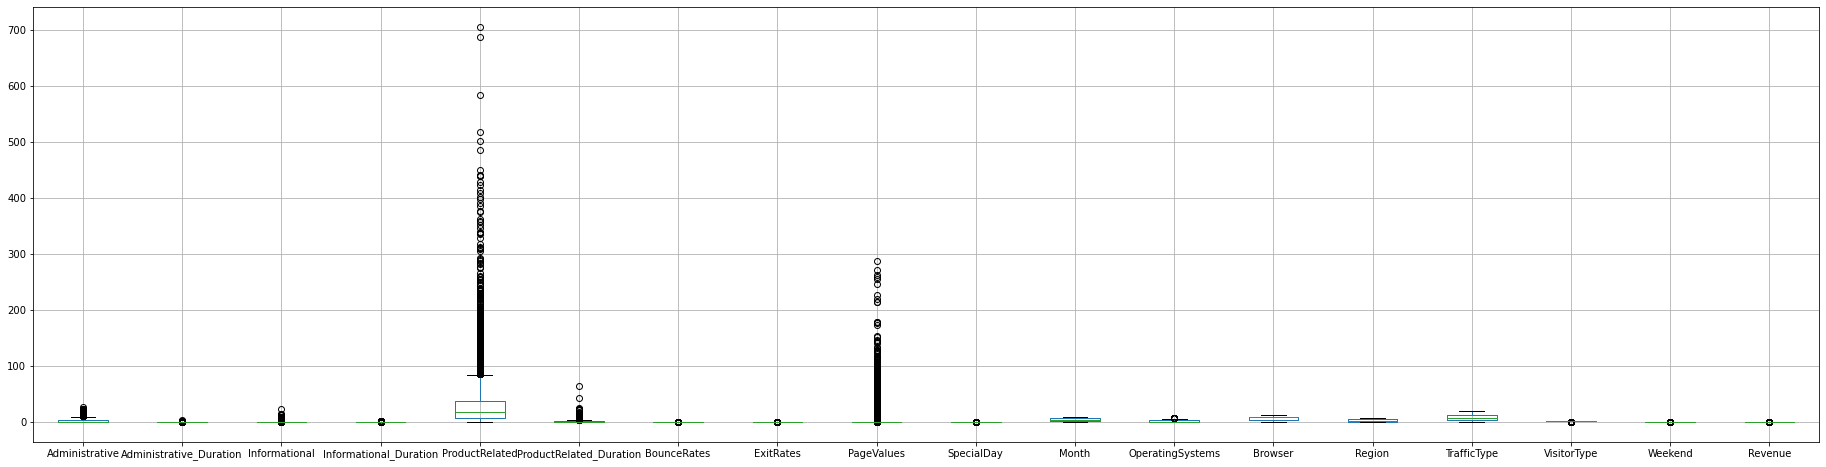

In [12]:
train.boxplot(figsize=(32,8))

In [13]:
numericalColumnsTransform = []

for col in NUM_COLS:
    numericalColumnsTransform.append(
        (f'{col}_impute', SimpleImputer(strategy="mean"), [col]),
    )
#     numericalColumnsTransform.append(
#         (f'{col}_scale', MinMaxScaler(), [col]),
#     )

numericalColumnsTransformer = ColumnTransformer(numericalColumnsTransform)

In [14]:
categoricalColumnsTransform = []

for col in CAT_COLS:
    categoricalColumnsTransform.append(
        (f'{col}_impute', SimpleImputer(strategy="most_frequent"), [col]),
    )
    categoricalColumnsTransform.append(
        (f'{col}_onehot', OneHotEncoder(handle_unknown='ignore'), [col]),
    )

categoricalColumnsTransformer = ColumnTransformer(categoricalColumnsTransform)

In [15]:
Transformer = ColumnTransformer([*numericalColumnsTransform, *categoricalColumnsTransform])

In [115]:
def pipeBuilder(modelClass, **kwargs) -> Pipeline:
    return Pipeline([
        ('transform', Transformer),
        ('classifier', modelClass(**kwargs)),
    ])

# selection

經由 stratified 10 fold CV
挑選演算法

訓練集中 85%為沒訂房，15%為訂房

In [116]:
pipes = {
    "logistic": pipeBuilder(LogisticRegression, max_iter=100),
    "rf": pipeBuilder(RandomForestClassifier),
    "df": pipeBuilder(DecisionTreeClassifier),
    "svc": pipeBuilder(SVC),
}

In [21]:
# def split_wrapper(df: pd.DataFrame, targetCol: str, splitRatio: float = 0.2) -> Tuple[pd.DataFrame]:
#     return train_test_split(df.drop(columns=[targetCol]), df[targetCol], test_size= splitRatio, stratify=df[targetCol])

In [22]:
# X_train, X_test, y_train, y_test = split_wrapper(train, TARGET)

In [109]:
cv = StratifiedKFold(n_splits=10)

In [24]:
cvResults = {
    modelName: cross_validate(pipe, train.drop(columns=[TARGET]), train[TARGET], cv=cv)
    for modelName, pipe in pipes.items()
}

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [25]:
scores = {
    modelName: cvResult['test_score']
    for modelName, cvResult in cvResults.items()
}

In [27]:
{modelName: np.mean(score) for modelName, score in scores.items()}

{'logistic': 0.8816049382716049,
 'rf': 0.8969135802469135,
 'df': 0.8580246913580247,
 'svc': 0.8941975308641975}

# tuning

In [118]:
tunePipes = {
    index: pipeBuilder(RandomForestClassifier, max_depth=depth)
    for index, depth in enumerate([5, 9, 15])
}

In [119]:
cv = StratifiedKFold(n_splits=10)

In [120]:
cvResults = {
    modelName: cross_validate(pipe, train.drop(columns=[TARGET]), train[TARGET], cv=cv)
    for modelName, pipe in tunePipes.items()
}

In [121]:
scores = {
    modelName: cvResult['test_score']
    for modelName, cvResult in cvResults.items()
}

In [122]:
{modelName: np.mean(score) for modelName, score in scores.items()}

{0: 0.852962962962963, 1: 0.892469135802469, 2: 0.9003703703703703}

# training

In [123]:
rfPipe = pipeBuilder(RandomForestClassifier)

In [124]:
X, Y = train.drop(columns=[TARGET]), train[TARGET]

In [125]:
rfPipe.fit(X, Y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('Administrative_impute',
                                                  SimpleImputer(),
                                                  ['Administrative']),
                                                 ('Administrative_Duration_impute',
                                                  SimpleImputer(),
                                                  ['Administrative_Duration']),
                                                 ('Informational_impute',
                                                  SimpleImputer(),
                                                  ['Informational']),
                                                 ('Informational_Duration_impute',
                                                  SimpleImputer(),
                                                  ['Informational_Duration']),
                                                 ('ProductRela...
                    

# features

從gini係數的角度來看，最有影響力的特徵是
1. 頁面價值
2. 退出率
3. 產品頁面瀏覽時間

從分布上來看也符合

In [127]:
clf = rfPipe.named_steps['classifier']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]),
 [Text(0, 0, 'Administrative'),
  Text(1, 0, 'Administrative_Duration'),
  Text(2, 0, 'Informational'),
  Text(3, 0, 'Informational_Duration'),
  Text(4, 0, 'ProductRelated'),
  Text(5, 0, 'ProductRelated_Duration'),
  Text(6, 0, 'BounceRates'),
  Text(7, 0, 'ExitRates'),
  Text(8, 0, 'PageValues'),
  Text(9, 0, 'SpecialDay'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0,

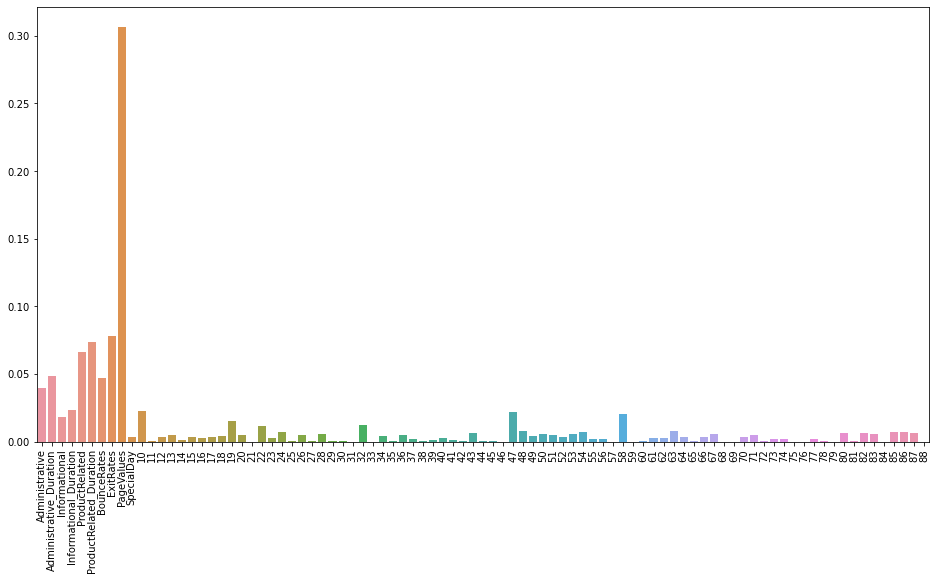

In [128]:
featureImportance = clf.feature_importances_
featureName = [NUM_COLS[i] if i < len(NUM_COLS) else i for i in range(len(fi))]
plt.figure(figsize=(16,8))
sb.barplot(x=featureName, y=featureImportance)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='ExitRates', ylabel='Density'>

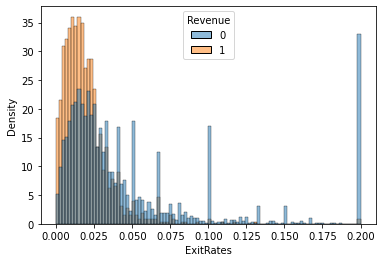

In [105]:
sb.histplot(data=train, x="ExitRates", hue="Revenue", bins=100, stat="density", common_norm=False,)

<AxesSubplot:xlabel='PageValues', ylabel='Density'>

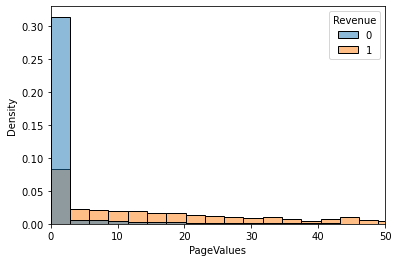

In [104]:
plt.xlim(0, 50)
sb.histplot(data=train, x="PageValues", hue="Revenue", bins=100, stat="density", common_norm=False,)

<AxesSubplot:xlabel='ProductRelated_Duration', ylabel='Density'>

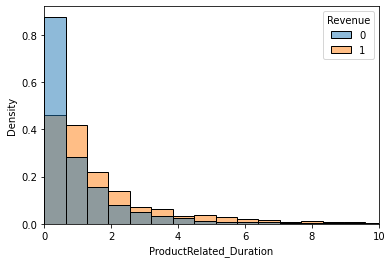

In [103]:
plt.xlim(0, 10)
sb.histplot(data=train, x="ProductRelated_Duration", hue="Revenue", bins=100, stat="density", common_norm=False,)

In [1]:
# explainer = shap.TreeExplainer(clf, X)
# shap_values = explainer.shap_values(X)

In [ ]:
# shap.plots.force(shap_values)

In [ ]:
# shap.plots.scatter(shap_values)

In [ ]:
# shap.plots.beeswarm(shap_values)

In [ ]:
# shap.plots.bar(shap_values)

# submit

In [68]:
test = pd.read_csv("test.csv", index_col=["ID"])
submit = pd.read_csv("sample_submission.csv")

In [69]:
test['HasRevenue'] = rfPipe.predict_proba(test)[:, 1]

In [71]:
test.to_csv("sumbit.csv", index=False)

In [72]:
test.sort_index().reset_index()[['ID', 'HasRevenue']]

,ID,HasRevenue
0,3,0.15
1,10,0.05
2,14,0.14
3,36,0.13
4,37,0.26
...,...,...
895,8946,0.17
896,8959,0.06
897,8960,0.03
898,8976,0.55


# 加分題

In [31]:
CM_A = np.array([
    [853,576],
    [341,7230],
])

CM_B = np.array([
    [846,583],
    [316,7255],
])

In [45]:
def accuracy(cm: np.ndarray) -> float:
    return cm.trace()/cm.sum()

In [49]:
def precision(cm: np.ndarray) -> float:
    return cm[0,0]/cm[:,0].sum()

In [46]:
def specificity(cm: np.ndarray) -> float:
    return cm[0,0]/cm[0].sum()

In [60]:
def chisq(cm: np.ndarray) -> float:
    stat, p, df, obs = chi2_contingency(cm)
    return p

In [74]:
from scipy.stats import binom_test

In [61]:
metrics = [
    {
         "model": "A", 
         "accuracy": accuracy(CM_A), 
         "precision": precision(CM_A),
         "specificity": specificity(CM_A),
         "significance": chisq(CM_A),
    },
    {
        "model": "B", 
         "accuracy": accuracy(CM_B), 
         "precision": precision(CM_B),
         "specificity": specificity(CM_B),
         "significance": chisq(CM_B),
    },
]

In [79]:
metrics = pd.DataFrame(metrics).set_index("model")
metrics

,accuracy,precision,specificity,significance
model,,,,
A,0.898111,0.714405,0.596921,0.0
B,0.900111,0.728055,0.592022,0.0


In [81]:
metrics.diff()

,accuracy,precision,specificity,significance
model,,,,
A,NaN,NaN,NaN,NaN
B,0.002,0.01365,-0.004899,0.0


兩個模型差異不大，Model B 主要在precision的部分略高於 Model A的表現

若 Model B 預測的名單共10000則廣告，平均而言會比 Model A 多100次點擊